In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot 
from scipy import interp
import scipy.stats
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

#### Goal
--------------------

The goal of this project is to make a classifier that predicts the final rankings for bakers.
The idea is to make a model for each episode and to use data from previous episodes in the model.
Therefore, a classifier for episode 1 will likely be bad at predicting the final outcome, but a classifier for episode 5 might accurately predict who will be in the top 3 and who might be eliminated in the next episode



In [2]:
from datetime import datetime
def timestamp(): return datetime.today().strftime('%Y%m%d')

from sklearn.preprocessing import QuantileTransformer
def quantile_scale(df,feats):
    qua = df
    scaler = QuantileTransformer(
        n_quantiles=10,
        random_state=42,
        ignore_implicit_zeros=True, #sparse matrix
    )
    # fit the scaler
    scaler.fit(qua[feats])
    # transform values
    qua[feats] = scaler.transform(qua[feats])
    return qua
def tiered(classes):
    trans = []
    for x in classes:
        if x==1: c=0
        if x==2: c=1
        if x>=3 and x<=4: c=2
        if x>=5 and x<=7: c=3
        if x>=8: c=4
        trans.append(c)
    return trans

In [3]:
merge_col = ['season','baker','index','episode','place']
tech = pd.read_csv("../RESULTS/gbbo.techinical.data.s10.20190920.tsv",sep="\t")
star = pd.read_csv("../RESULTS/gbbo.starbaker.data.s10.e4.20190920.tsv",sep="\t")
gbbo = pd.merge(tech, star,  how='left', left_on=merge_col, right_on =merge_col)
gbbo = gbbo[['season','baker','episode','place','tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']]
gbbo.to_csv("../RESULTS/gbbo.features.s10.e4.{}.tsv".format(timestamp()),sep="\t",index=False)
gbbo.head()

,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
0,10,Alice,1,0,5.00,5,0.00,0,0.00,0,0.00,0
1,10,Alice,2,0,3.00,1,0.50,1,0.50,1,0.00,0
2,10,Alice,3,0,4.33,7,0.33,0,0.33,0,0.33,1
3,10,Alice,4,0,5.25,8,0.25,0,0.25,0,0.25,0
4,10,Amelia,1,11,4.00,4,0.00,0,0.00,0,0.00,0


In [4]:
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e4.20190920.tsv",sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
gbbo.head()

,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
3,10,Alice,4,0,3.888889e-01,8.333333e-01,8.333333e-01,1.000000e-07,6.666667e-01,1.000000e-07,6.666667e-01,1.000000e-07
7,10,Amelia,4,11,6.111111e-01,1.000000e-07,8.333333e-01,1.000000e-07,1.000000e-07,1.000000e-07,6.666667e-01,1.000000e-07
11,10,Dan,4,13,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,6.666667e-01,1.000000e-07
15,10,David,4,0,2.037037e-01,3.333333e-01,1.000000e-07,1.000000e-07,8.888889e-01,9.999999e-01,1.000000e-07,1.000000e-07
19,10,Helena,4,0,9.999999e-01,9.166667e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07


In [5]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.activations import relu
input_shape = len(feats)
output_shape = len(set(tech['place']))
def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0,input_shape=input_shape,output_shape=output_shape):    
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture
    https://www.kaggle.com/arrogantlymodest/randomised-cv-search-over-keras-neural-network
    '''
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
    model = Sequential()
    first=True  
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))       
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    return model
##################################
l1 = 0.0001
l2 = 0.0001
lr = 0.0001
nl1 = 1
nl2 = 1
nl3 = 1
nn1 = 800
nn2 = 800
nn3 = 300

dropout = 0.1
decay = 1e-09
act='relu'
n_dims = len(feats)
n_classes = len(set(tech['place']))

nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)

BATCH,EPOCHS = 12, 25
####
X, y = np.matrix(qua[feats]), np.array(qua['place'])
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e4.20190920.tsv",sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])

tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)

preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
# probability baker is a finalist or a runner-up
top3 = probs[:,0]+probs[:,1]
# bottom tier (8th and below)
bot = probs[:,-1]
# 5th - 7th
nextbot = probs[:,-2]
third = probs[:,-3]

gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
gbbo['fifthseventh'] = np.round(nextbot*100,decimals=2)
gbbo['thirdforth'] = np.round(third*100,decimals=2)

gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e4.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom','fifthseventh','thirdforth']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)
print(gbbo)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
       baker  preds   finalist       top3     bottom  fifthseventh  thirdforth
47     Rosie      2  23.770000  44.080002   6.160000     21.540001   28.230000
3      Alice      3  19.719999  40.000000   3.260000     30.340000   26.400000
31   Michael      2  13.350000  20.160000  13.330000     32.720001   33.790001
15     David      1  13.270000  64.349998   1.660000     16.330000   17.660000
51     Steph      1   7.860000  73.519997   0.540000     15.760000   10.180000
35  Michelle      3   7.820000  18.129999   7.200000     47.880001   26.790001
23     Henry      3   6.460000  11.750000  29.580000     37.770000   20.900000
19    Helena      3   4.170000  10.800000   2.980000     61.160000   25.070000
11       Dan      4   3.250000   5.510000  78.489998  

In [7]:
gbbo = gbbo[sub].sort_values(by=['bottom'],ascending=False)
print(gbbo)

       baker  preds   finalist       top3     bottom  fifthseventh  thirdforth
27     Jamie      4   0.370000   0.620000  96.120003      1.470000    1.790000
7     Amelia      4   2.910000   5.340000  84.430000      4.580000    5.660000
11       Dan      4   3.250000   5.510000  78.489998      8.600000    7.400000
39      Phil      3   1.300000   2.090000  36.400002     44.320000   17.190001
23     Henry      3   6.460000  11.750000  29.580000     37.770000   20.900000
31   Michael      2  13.350000  20.160000  13.330000     32.720001   33.790001
43     Priya      3   0.870000   1.490000  12.460000     70.339996   15.720000
35  Michelle      3   7.820000  18.129999   7.200000     47.880001   26.790001
47     Rosie      2  23.770000  44.080002   6.160000     21.540001   28.230000
3      Alice      3  19.719999  40.000000   3.260000     30.340000   26.400000
19    Helena      3   4.170000  10.800000   2.980000     61.160000   25.070000
15     David      1  13.270000  64.349998   1.660000

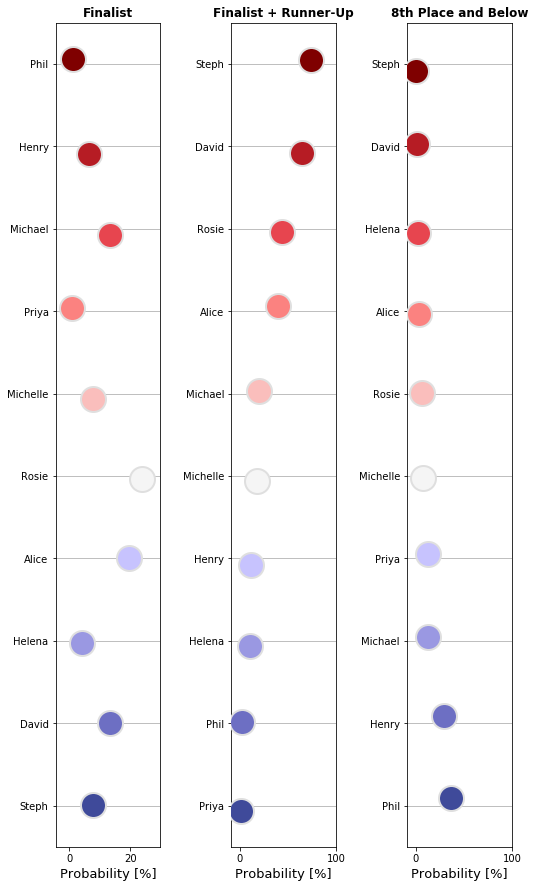

In [8]:
def plot_probs(df,x,xlab,ax,xmin=-9,xmax=100):
    #col=['#012169', '#3d4081', '#64629a', '#8b87b2', '#b1adcc', '#d7d5e5', '#ffffff', '#fddcd9', '#f8b9b4', '#f09790', '#e5736d', '#d84c4d', '#c8102e']
    col=['#122771', '#3f4a9a', '#6d6fc3', '#9a98e2', '#c7c3fe', '#f5f5f5', '#fabebc', '#fb8280', '#e7454f', '#b61c24', '#7f0000']
    colrs=reversed(col)

    vapeplot.font_size(12)
    #f, ax = plt.subplots(1,1,figsize=(2.5,5*2.5))
    sns.stripplot(
        y='baker',
        x=x,
        data=df,
        linewidth=2, 
        edgecolor="#dfdfdf",
        size=25,
        ax=ax,
        palette=colrs
    )
    ax.set_ylabel('')
    ax.yaxis.grid(True)
    ax.set_xlim(xmin,xmax)
    ax.set_title(xlab,fontsize=12,weight='bold')
    ax.set_xlabel('Probability [%]',fontsize=13)

nrow=1
ncol=3

f, ax = plt.subplots(nrow,ncol,figsize=(ncol*2.5,nrow*5*2.5))

lost = ['Dan','Jamie','Amelia']
gbbo = gbbo.loc[~gbbo['baker'].isin(lost)]

plot_probs(gbbo,'finalist','Finalist',ax[0],-4.5,30)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),
           'top3','Finalist + Runner-Up',ax[1])
plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),
           'bottom','8th Place and Below',ax[2])

f.tight_layout()
f.savefig('../FIGURES/s10e4.preds.png',dpi=150)
f.show()
